In [ ]:
import numpy as np
import pandas as pd
import os
# import wget
import zipfile
import plotly.graph_objects as go
from tqdm import trange
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pd.options.plotting.backend = "plotly"
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [ ]:
df = pd.read_csv("/content/household_power_consumption.txt", sep = ';',
                 low_memory=False, na_values=['nan', '?'])
data = df
print(len(df))


2075259


In [ ]:
df = df.iloc[0:1000]
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

df.head()

<ipython-input-43-f89c094356df>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


##EDA

In [ ]:
data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

In [ ]:
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data = data.dropna(subset=['Global_active_power'])

In [ ]:
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)

In [ ]:
data = data.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]

data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)

In [ ]:
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [ ]:
print(data.shape)

print(data.date_time.min())
print(data.date_time.max())

data.tail(5)

(2049280, 7)
2006-12-16 17:24:00
2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.690,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.688,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.688,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.688,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.688,2010,4,12,11,0


<ipython-input-50-9cbc4bbbcd70>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Global_active_power', ylabel='Density'>

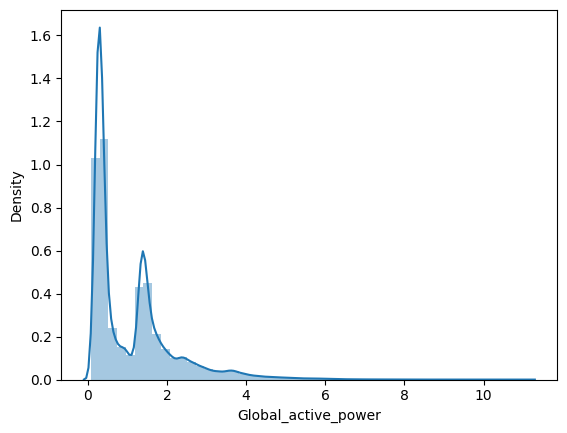

In [ ]:
sns.distplot(data.Global_active_power)

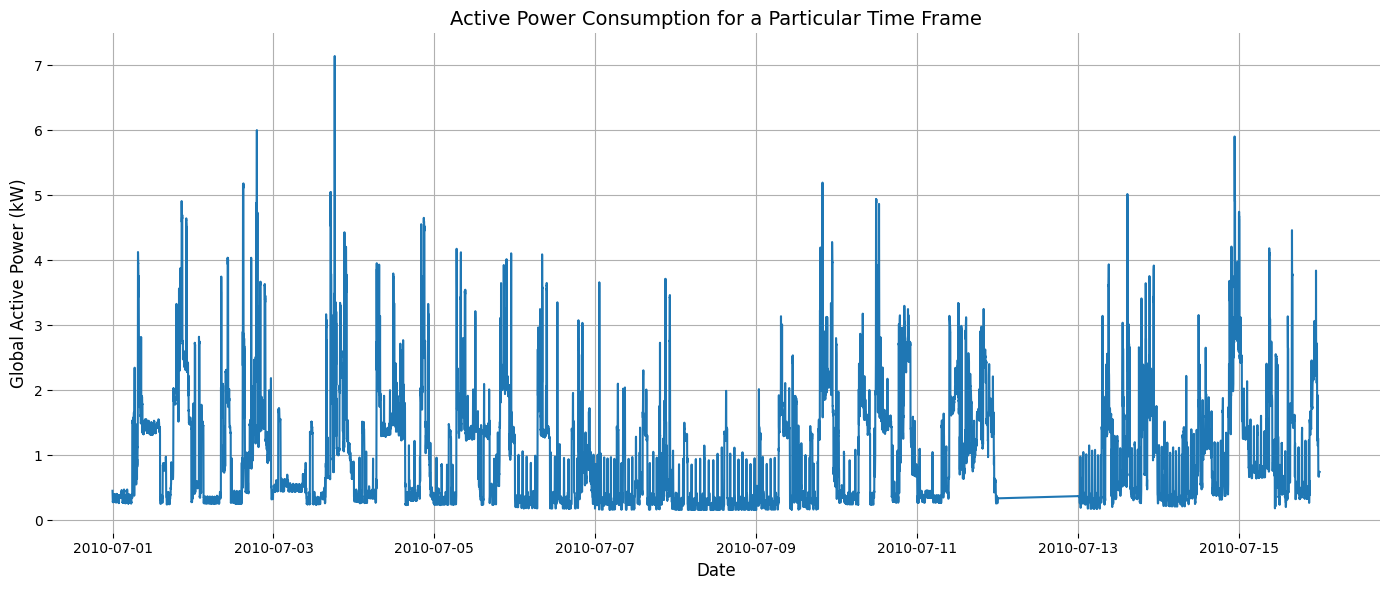

In [ ]:
data1 = data[(data.date_time >= '2010-07-01') & (data.date_time < '2010-7-16')]

plt.figure(figsize=(14,6))
plt.plot(data1.date_time, data1.Global_active_power)
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Active Power Consumption for a Particular Time Frame', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True, left=True)
plt.show()

In [ ]:
data1=data.loc[:,['date_time','Global_active_power']]
data1.set_index('date_time',inplace=True)

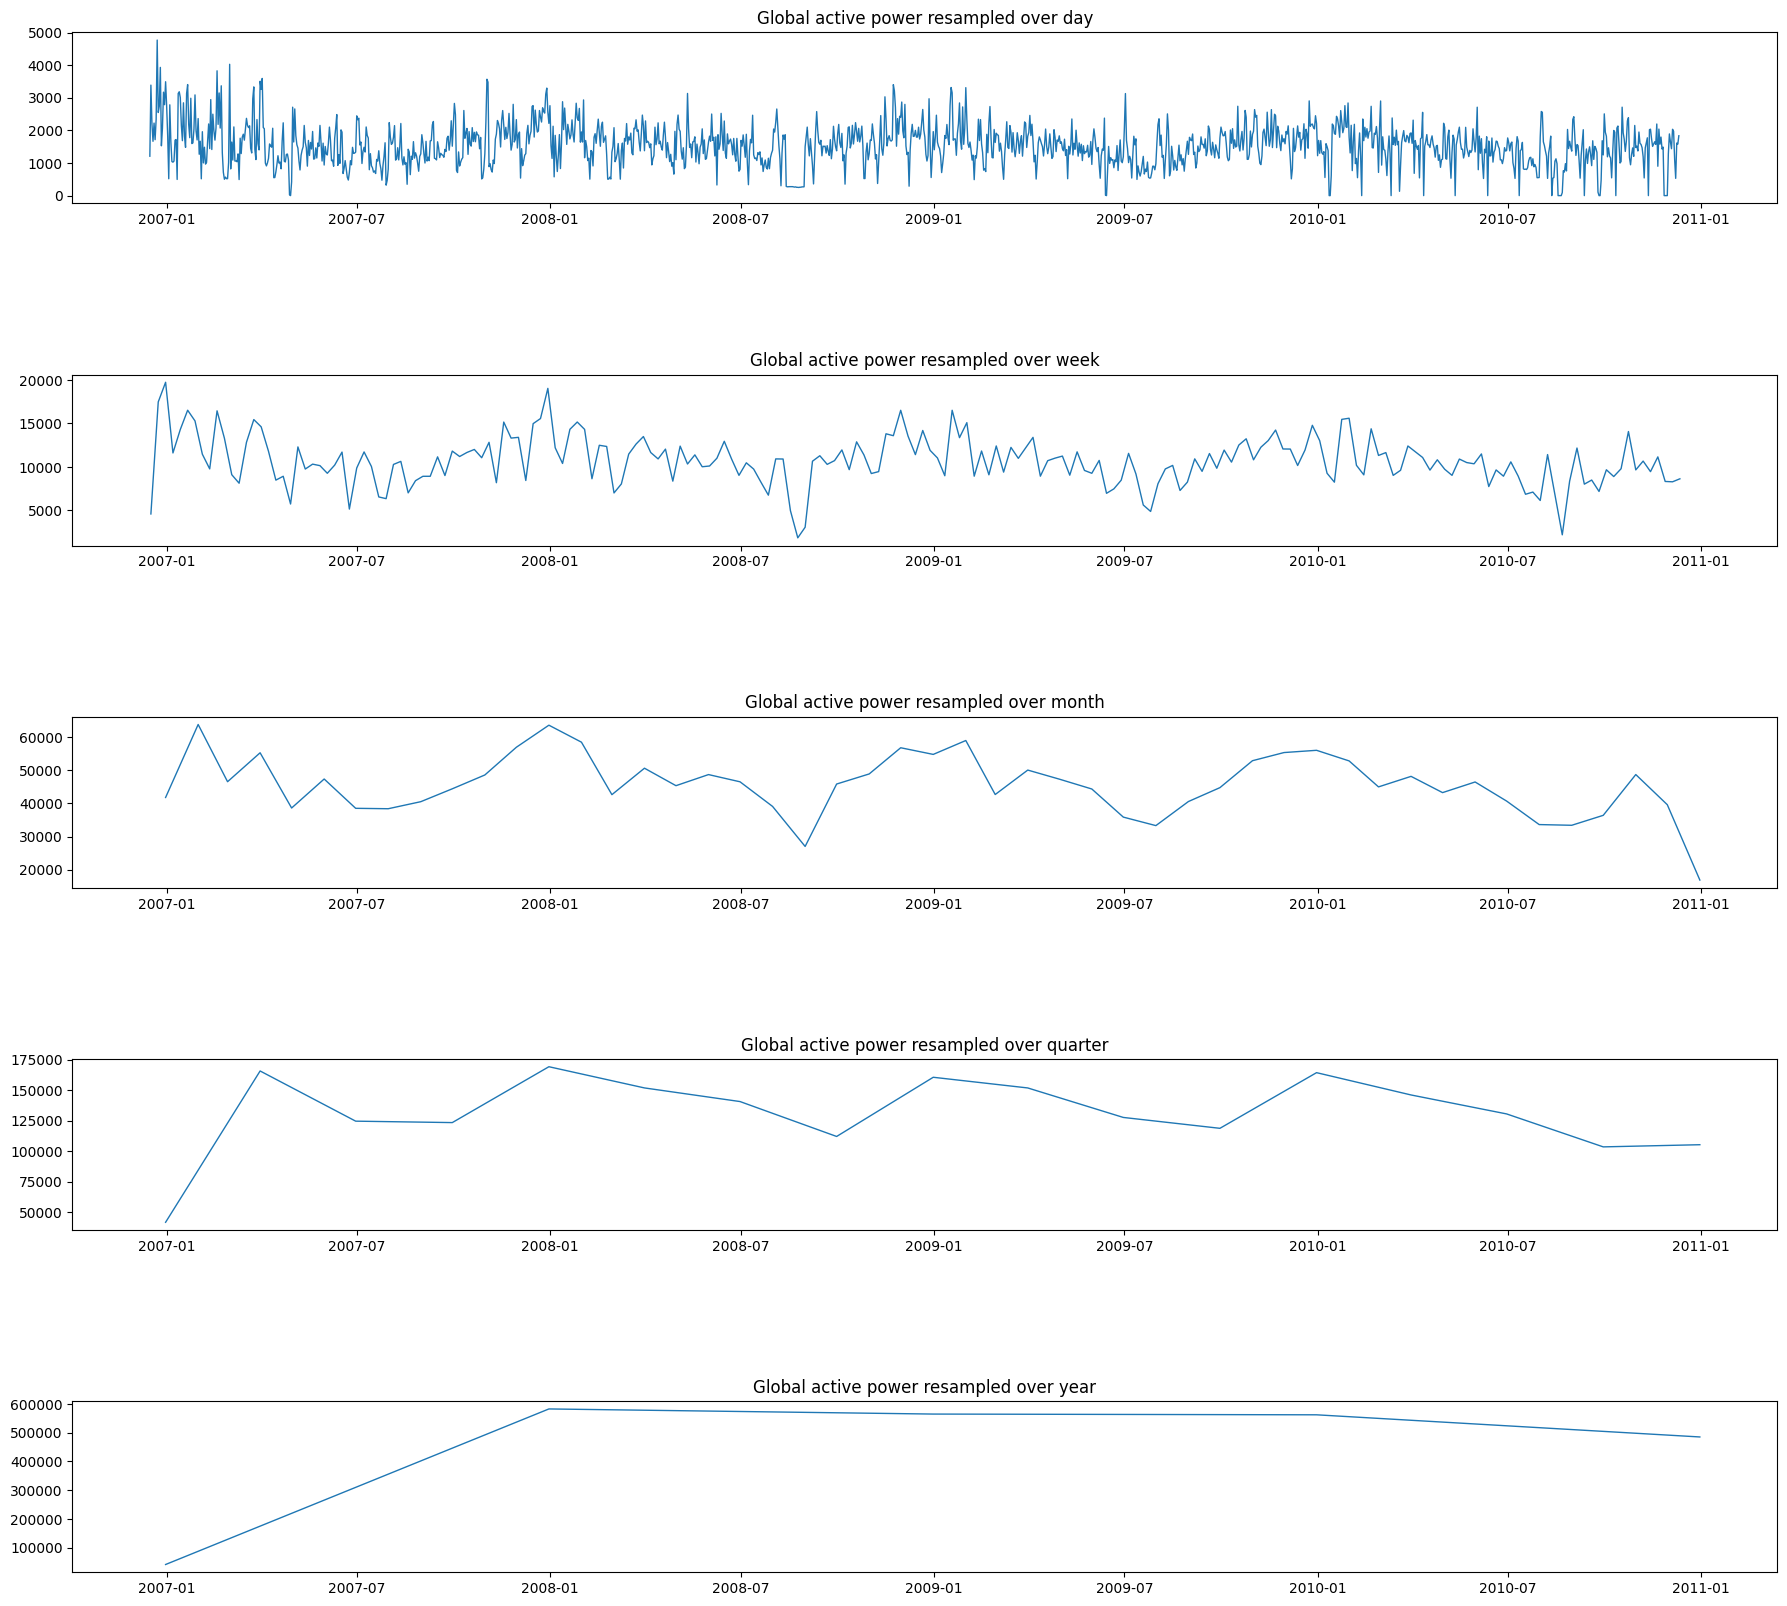

In [ ]:
# Create a figure with specified size
fig = plt.figure(figsize=(22,20))
# Adjust the subplot spacing
fig.subplots_adjust(hspace=1)

# Create first subplot
ax1 = fig.add_subplot(5,1,1)
# Plot the resampled mean of Global_active_power over day with different color
ax1.plot(data1['Global_active_power'].resample('D').sum(), linewidth=1)
# Set the title for the subplot
ax1.set_title('Global active power resampled over day')
# Set major tick parameters for the subplot
ax1.tick_params(axis='both', which='major')

# Create second subplot
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
# Plot the resampled mean of Global_active_power over week with different color
ax2.plot(data1['Global_active_power'].resample('W').sum(), linewidth=1)
# Set the title for the subplot
ax2.set_title('Global active power resampled over week')
# Set major tick parameters for the subplot
ax2.tick_params(axis='both', which='major')

# Create third subplot
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax3.plot(data1['Global_active_power'].resample('M').sum(), linewidth=1)
# Set the title for the subplot
ax3.set_title('Global active power resampled over month')
# Set major tick parameters for the subplot
ax3.tick_params(axis='both', which='major')

# Create third subplot
ax4  = fig.add_subplot(5,1,4, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax4.plot(data1['Global_active_power'].resample('Q').sum(),linewidth=1)
# Set the title for the subplot
ax4.set_title('Global active power resampled over quarter')
# Set major tick parameters for the subplot
ax4.tick_params(axis='both', which='major')


# Create third subplot
ax5  = fig.add_subplot(5,1,5, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax5.plot(data1['Global_active_power'].resample('A').sum(),linewidth=1)
# Set the title for the subplot
ax5.set_title('Global active power resampled over year')
# Set major tick parameters for the subplot
ax5.tick_params(axis='both', which='major')

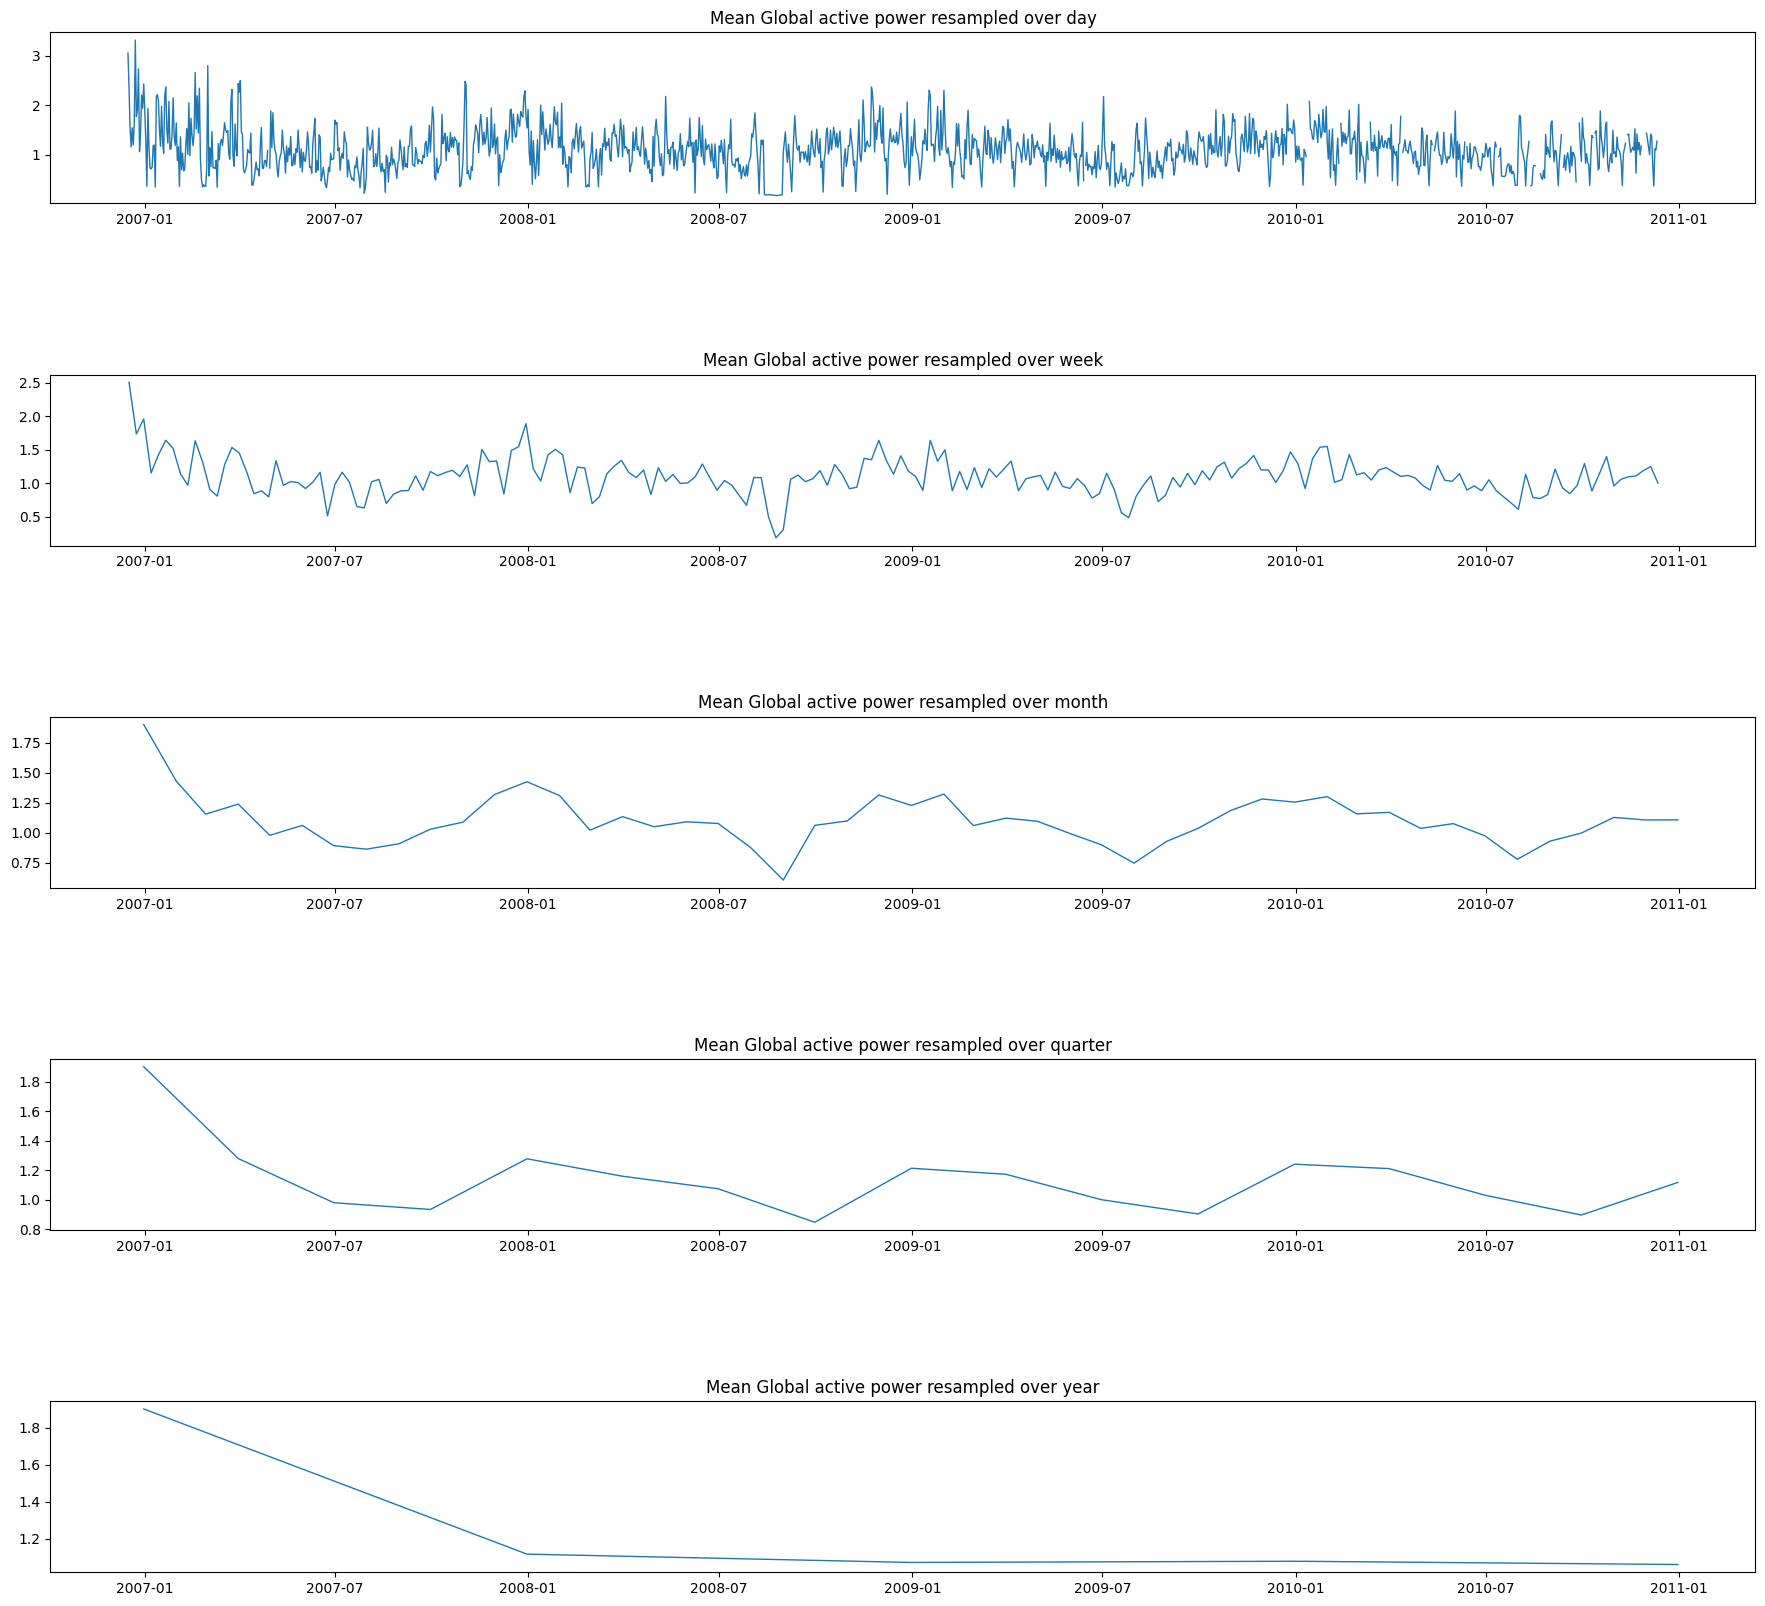

In [ ]:
# Create a figure with specified size
fig = plt.figure(figsize=(22,20))
# Adjust the subplot spacing
fig.subplots_adjust(hspace=1)

# Create first subplot
ax1 = fig.add_subplot(5,1,1)
# Plot the resampled mean of Global_active_power over day with different color
ax1.plot(data1['Global_active_power'].resample('D').mean(), linewidth=1)
# Set the title for the subplot
ax1.set_title('Mean Global active power resampled over day')
# Set major tick parameters for the subplot
ax1.tick_params(axis='both', which='major')

# Create second subplot
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
# Plot the resampled mean of Global_active_power over week with different color
ax2.plot(data1['Global_active_power'].resample('W').mean(), linewidth=1)
# Set the title for the subplot
ax2.set_title('Mean Global active power resampled over week')
# Set major tick parameters for the subplot
ax2.tick_params(axis='both', which='major')

# Create third subplot
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax3.plot(data1['Global_active_power'].resample('M').mean(), linewidth=1)
# Set the title for the subplot
ax3.set_title('Mean Global active power resampled over month')
# Set major tick parameters for the subplot
ax3.tick_params(axis='both', which='major')

# Create third subplot
ax4  = fig.add_subplot(5,1,4, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax4.plot(data1['Global_active_power'].resample('Q').mean(),linewidth=1)
# Set the title for the subplot
ax4.set_title('Mean Global active power resampled over quarter')
# Set major tick parameters for the subplot
ax4.tick_params(axis='both', which='major')


# Create third subplot
ax5  = fig.add_subplot(5,1,5, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax5.plot(data1['Global_active_power'].resample('A').mean(),linewidth=1)
# Set the title for the subplot
ax5.set_title('Mean Global active power resampled over year')
# Set major tick parameters for the subplot
ax5.tick_params(axis='both', which='major')

#Dummy Variables

In [ ]:
# 더미 변수로 변환할 특정 컬럼 선택
columns_to_dummy = ['Global_active_power']
df_dummy = pd.get_dummies(df["Global_active_power"], drop_first=True)

df_concat = pd.concat([df, df_dummy], axis=1)

df_concat

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,...,6.072,6.104,6.308,6.474,6.58,6.752,6.926,7.026,7.064,7.706
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,...,0,0,0,0,0,0,0,0,0,0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,...,0,0,0,0,0,0,0,0,0,0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,...,0,0,0,0,0,0,0,0,0,0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,...,0,0,0,0,0,0,0,0,0,0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,17/12/2006,09:59:00,2.296,0.054,238.13,9.6,0.0,0.0,0.0,2006-12-17 09:59:00,...,0,0,0,0,0,0,0,0,0,0
996,17/12/2006,10:00:00,2.292,0.054,238.03,9.6,0.0,0.0,0.0,2006-12-17 10:00:00,...,0,0,0,0,0,0,0,0,0,0
997,17/12/2006,10:01:00,0.370,0.000,240.26,2.4,0.0,0.0,0.0,2006-12-17 10:01:00,...,0,0,0,0,0,0,0,0,0,0
998,17/12/2006,10:02:00,0.472,0.000,240.15,2.4,0.0,0.0,0.0,2006-12-17 10:02:00,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Global_active_power
split_rate = 0.8
train_df, test_df = df[0:int(len(df) * split_rate)], df[int(len(df) * split_rate):]

train_ar = train_df['Global_active_power'].values
test_ar = test_df['Global_active_power'].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df['Datetime'], y=train_df['Global_active_power'],
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=test_df['Datetime'], y=test_df['Global_active_power'],
                    mode='lines',
                    name='test'))

fig.update_layout(title='Dataset',
                   xaxis_title='Datetime',
                   yaxis_title='Global Active Power')

fig.show()

In [ ]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))

<class 'list'>


In [ ]:
rsq_list, rmse_list, mape_list, mae_list = [],[],[],[]

##ARIMA

In [ ]:
### ARIMA
predictions = list()
for t in trange(len(test_ar)):
    model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))


100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


In [ ]:
# R2
Arima_r2 = r2_score(test_ar, predictions)
# print('R2: %.3f' % Arima_r2)

#RMSE
Arima_RMSE = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.6f' % Arima_RMSE)

#MAE
Arima_MAPE = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % Arima_MAPE)

# MAPE 계산
Arima_MAE = np.mean(np.abs((test_ar - predictions) / test_ar)) * 100
# print("MAE: ", Arima_MAE)

# print(model_eval(test_ar, predictions))

rsq_list.append(Arima_r2)
rmse_list.append(Arima_RMSE)
mape_list.append(Arima_MAPE)
mae_list.append(Arima_MAE)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df['Datetime'], y=train_df['Global_active_power'],
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=test_df['Datetime'], y=test_df['Global_active_power'],
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=test_df['Datetime'], y=predictions,
                    mode='lines+markers',
                    name='predictions'))

fig.update_layout(title='Training Result (arima)',
                   xaxis_title='Datetime',
                   yaxis_title='Global Active Power')

fig.show()

##Holt-winters

In [ ]:
### Holt-Winters
predictions = list()
for t in trange(len(test_ar)):
    model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))

100%|██████████| 200/200 [00:56<00:00,  3.56it/s]


In [ ]:
holt_r2 = r2_score(test_ar, predictions)
# print('R2: %.3f' % Arima_r2)

holt_RMSE = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.6f' % holt_RMSE)

holt_MAPE = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % holt_MAPE)

# MAPE 계산
holt_MAE = np.mean(np.abs((test_ar - predictions) / test_ar)) * 100
print("MAE: ", holt_MAE)

# print(model_eval(test_ar, predictions))

rsq_list.append(holt_r2)
rmse_list.append(holt_RMSE)
mape_list.append(holt_MAPE)
mae_list.append(holt_MAE)


Testing Mean Squared Error: 0.653736
Symmetric mean absolute percentage error: 35.315
MAE:  66.37002683796361


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df['Datetime'], y=train_df['Global_active_power'],
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=test_df['Datetime'], y=test_df['Global_active_power'],
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=test_df['Datetime'], y=predictions,
                    mode='lines+markers',
                    name='predictions'))

fig.update_layout(title='Training Result (arima)',
                   xaxis_title='Datetime',
                   yaxis_title='Global Active Power')

fig.show()

In [ ]:
meterics_df = pd.DataFrame()# records: models , columns: rsq, rmse, mape,mae

data = {'R_sq': rsq_list,
        'RMSE': rmse_list,
        'MAPE':mape_list,
        'MAE':mae_list}

meterics_df = pd.DataFrame(data, index=['ARIMA','holt-winters'])

print(meterics_df)

                  R_sq      RMSE       MAPE        MAE
ARIMA         0.570771  0.691794  36.250804  68.805212
holt-winters  0.594385  0.653736  35.314913  66.370027
